# Table of Contents
* [Assignment 5: Control a Marble with Reinforcement Learning](#Assignment-5:-Control-a-Marble-with-Reinforcement-Learning)
	* [Overview](#Overview)
	* [Start with This Code](#Start-with-This-Code)
	* [Requirements](#Requirements)
	* [Grading](#Grading)
	* [Extra Credit](#Extra-Credit)
	* [Check-in](#Check-in)


$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Control a Marble with Reinforcement Learning

*Sean Russell*

## Overview

In this assignment, you will be modifying the reinforcement learning code used to solve the dynamic marble problem.  You will be solving a more complex version of the marble problem in which a goal position is specified as a new state variable.

In [1]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

To define a reinforcement learning problem, we need functions that return

* initial the state of the environment,
* a next state given a current state and an action,
* a reinforcement value, and
* an action to take, given the current state. For this we define an $\epsilon$-greedy policy.

Let's first define the set of valid actions.  For our simple one-dimensional marble problem, we can push left, right, or not push at all.

In [3]:
validActions = np.array([ -1, 0, 1])

def initialState():
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample()),10*np.random.random_sample()])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0,s[2]])
    elif s[0] > 10:
        s = np.array([10,0,s[2]])
    return s

def reinforcement(s):  # s is new state
    goal = s[2]
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

Now we need a function to generate a bunch of samples that are interactions with the marble.

In [5]:
def makeSamples(qnet, nStepsPerStart):
    samples = []
    state = initialState()
    act = policy(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples)

Now we can play.  Define constants we need.

In [6]:
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace, goal=5):
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(4,3,2)
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [goal,goal],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[qnet.use([s,0,a]) for a in actions] for s in range(11)]
    qs = qnet.use(np.array([[s,0,g,a] for a in validActions for s in range(11) for g in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    plt.subplot(4,3,3)
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    plt.subplot(4,3,6)
    qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])

    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],goal,a] for a in validActions for i in range(len(xsflat))]))
    
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    plt.subplot(4,3,8)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")

    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")

    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")

def testIt(qnet,nTrials,nStepsPerTrial,goal):
    xs = np.linspace(0,10,nTrials)
    plt.subplot(4,3,12)
    for x in xs:
        s = [x,0,goal] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,3))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([goal,goal],[-5,5],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [7]:
gamma = 0.999
nTrials = 300
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

In [8]:
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (0,10), (-1,1)))

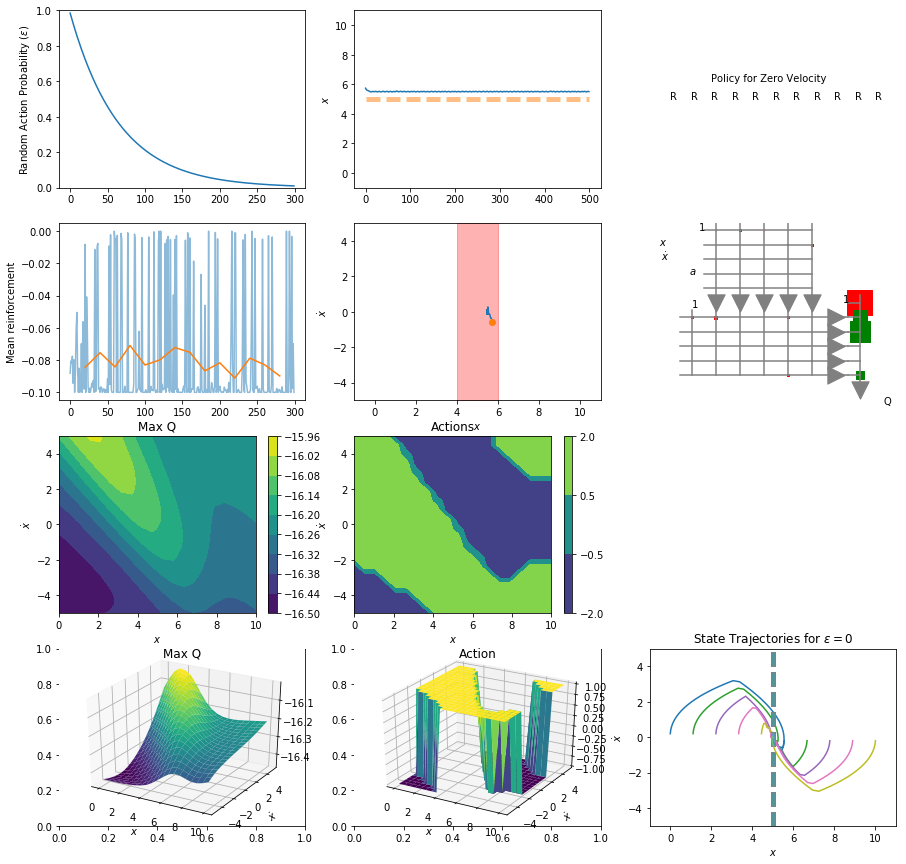

In [9]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)
    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)
    
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
        testIt(qnet,10,500,5)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

Here there be training

In [31]:
epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)

    numberstates = 3
    numberactions = 1
    X = samples[:, :numberstates+numberactions]
    R = samples[:, numberstates+numberactions:numberstates+numberactions+1]
    nextX = samples[:, numberstates+numberactions+1:]
    nextQ = qnet.use(nextX)
    
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

In [11]:
def generatePathPlot(qnet,nTrials,nStepsPerTrial,goal):
    xs = np.linspace(0,10,nTrials)
    for x in xs:
        s = [x,0,goal] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,3))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([goal,goal],[-5,5],'--',alpha=0.5,lw=5)

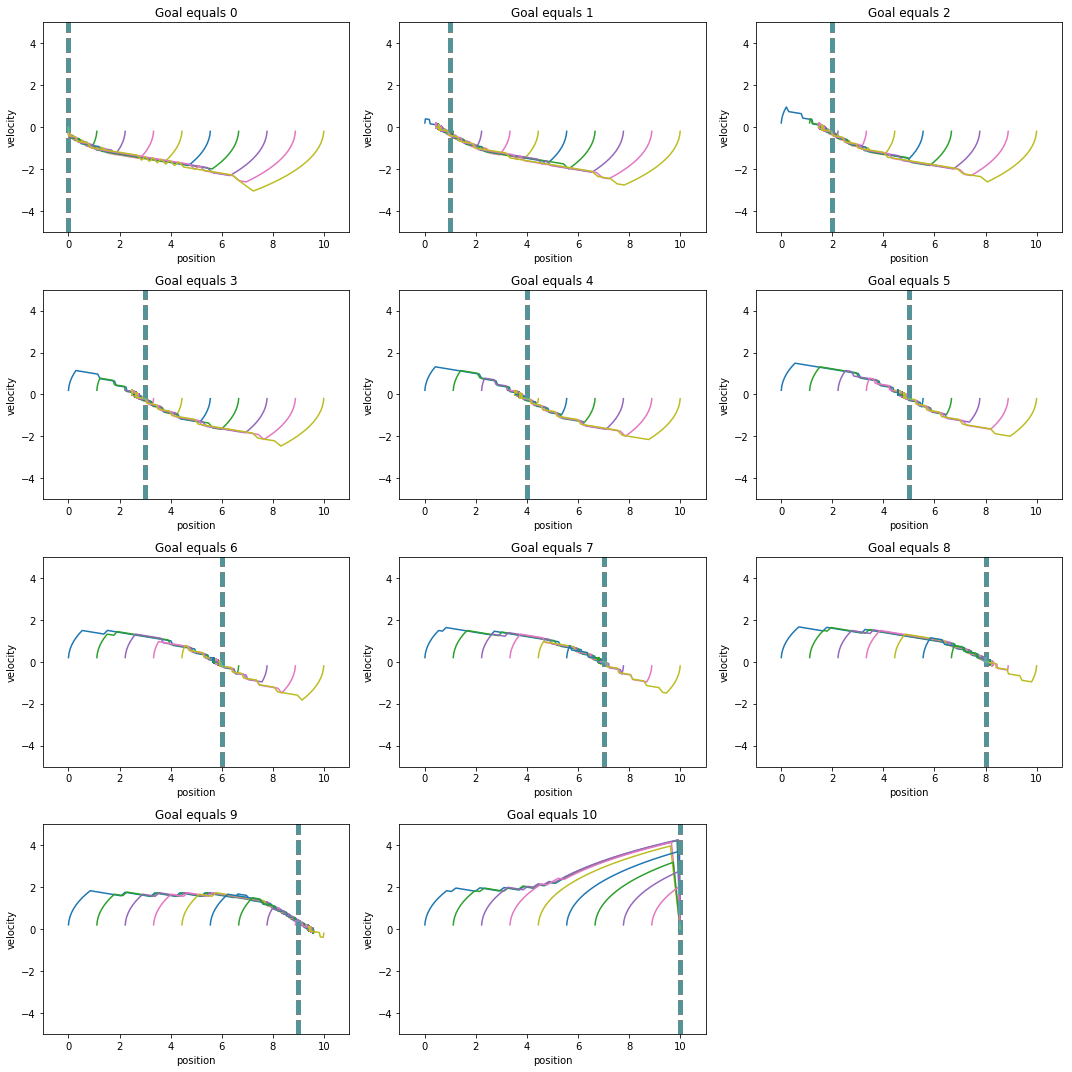

In [32]:
fig = plt.figure(figsize=(15,15))
for goal in range(11):
    plt.subplot(4,3,goal+1)
    generatePathPlot(qnet,10,500,goal)
    plt.xlabel('position')
    plt.ylabel('velocity')
    plt.title('Goal equals ' + str(goal))
    plt.tight_layout()

I think it's interesting that the marble learned to accelerate smoothly, but it decelerates in steps. Every trial I've run it does that, so I think it might be an advantageous strategy, or perhaps it is just an artifact of the way the computer learns. Also, when the goal is 10, the computer learned to just rush at the wall as fast as possible, because the wall will stop you at the goal perfectly.

In [173]:
def plotMaxQ(goal):
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],goal,a] for a in validActions for i in range(len(xsflat))]))
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("position")
    plt.ylabel("velocity")
    plt.title("Max Q")

def plotActions(goal):
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],goal,a] for a in validActions for i in range(len(xsflat))]))
    qs = qs.reshape((len(validActions),-1)).T
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("position")
    plt.ylabel("velocity")
    plt.title("Actions")

In [184]:
def plotFigs(goal):
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plotMaxQ(goal)
    plt.subplot(1,2,2)
    plotActions(goal)

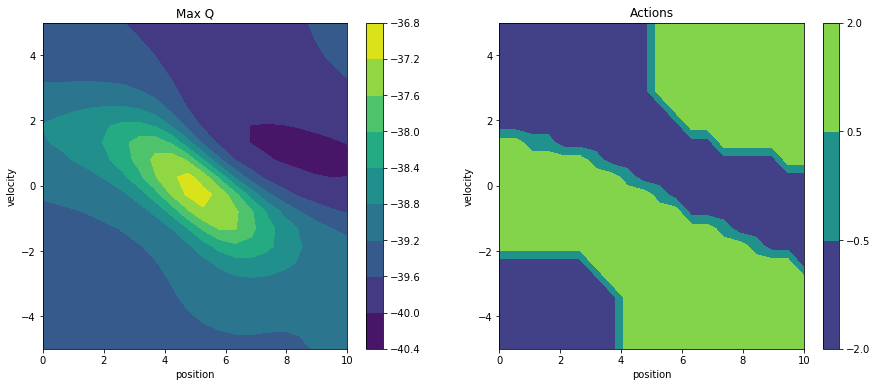

In [185]:
plotFigs(5)

In [28]:
def confidencePlot(goal):
    plt.figure(figsize=(10,10))
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat

    qs = qnet.use(np.array([[xsflat[i],ysflat[i],goal,a] for a in validActions for i in range(len(xsflat))]))

    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    qssum = np.sum(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax/qssum)
    plt.colorbar(cs)
    plt.xlabel("position")
    plt.ylabel("velocity")
    plt.title("confidence")

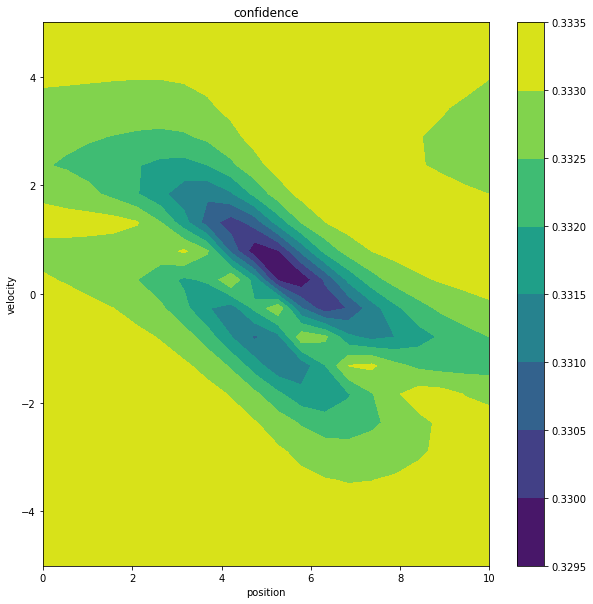

In [153]:
confidencePlot(5)

# JUST GOOFING OFF DOWN HERE

Many of the figures will still make sense. Include them in your report. The contour (and surface) plots and the plot that tests the marble's behavior for various intial positions must be produced for a single value of the goal. Generate several versions of the contour and surface plots and the test plots for goals of 1, 5, and 9 to show how they vary when the goal is varied.

I wanted to be able to visualize the actual movement of the marble. So, these functions are used in order to display the path of the marble. marbleToDestination() takes 100 steps using the learned model.

In [130]:
plt.plot?

In [147]:
def plotMarbleState(state):
    plt.axis('off')
    plt.xlim(-1,11)
    plt.ylim(-1,1)
    plt.xlabel('position')
    plt.plot(state[0],0,'o',markersize=20,label='marble')
    plt.plot([state[2],state[2]],[-5,5],'--',alpha=0.5,lw=5,label='goal')
    plt.legend(loc='upper left')

def marbleToDestination(state):
    fig = plt.figure()
    for i in range(100):
        if np.abs(state[0]-state[2]) < .1 or state[0]<=0 or state[0]>=10:
            break
        plt.clf()
        clear_output(wait=True)
        plotMarbleState(state)
        display(fig)
        #plt.pause(0.01)
        action = policy(qnet, state, 0.0)
        state = nextState(state,action)
    clear_output(wait=True)

So if you run this cell, you can see the marble make its way towards the goal from any given state.

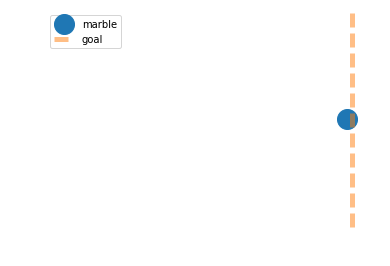

In [148]:
marbleToDestination([4,-1,10])

You can also see what happens when the initial state is not in the set of those generated by the initialState() function. For instance, if the velocity is above 1.5 or below -1.5, the network makes bizarre decisions.

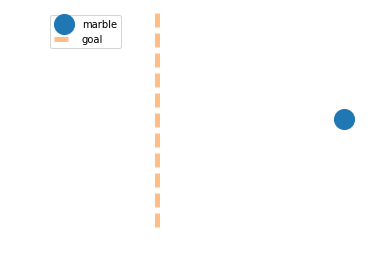

In [151]:
marbleToDestination([8,2,3])

The only times the marble had to deal with big velocities were when it had accelerated itself to those speeds, which normally means it is already heading in the right direction. So if you give it a big velocity, it seems that the network has learned its going the right way and won't always turn around.

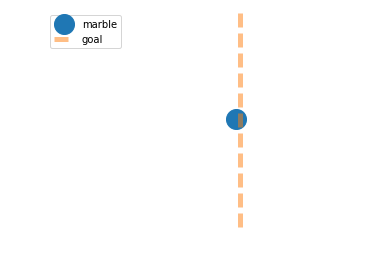

In [152]:
marbleToDestination([5,-2,6])

## Requirements

TODO:

experiment with different values for training network

plotFigs() for 1,5,9

full writeup

Modify the above code to change the
reinforcement learning problem to one for which the goal position of
the marble can be varied. In other words, your new code must train one Q network for the marble problem with a variable goal.  Run experiments to find a values for the network architecture (nh), gammam nTrials, nStepsPerTrial, nSCGIterations, and finalEpsilon that result in a single Q network that can drive the marble to the goal position.

The general approach is as follows.

The state of the marble is given by $(x_t,
\dot{x_t})$.  In this new problem, the state will be $(x_t,
\dot{x_t}, g_t)$, where $g_t$ is the goal at time $t$.  Modify the
`initialState` function to randomly choose a new goal $g_t$ to be a
random value between 1 and 9. Modify `nextState` so that the goal
value remains the same in the new state as it was in the old state.  You will also
have to parameterize the reinforcement function to depend on the
current $g_t$ value.

Experiment with values of the parameters, such as the number of trials, number of
steps per trial, number of hidden units, finalEpsilon, and gamma.  Try
to find values that result in a trained network that controls the
marble well for most of the goal settings.
Discuss your experience with finding good values.

Discuss the changes you tried and the results.

## Grading

To grade this notebook, we will run your complete notebook and read the results.  There is no automatic grading code for this notebook.  Do your best to show code and results you used to find good parameter values, to train your successful Q network, and to demonstrate that it is successful.

Include text to explain what you did, how successful it was, and any problems you encountered.

## Extra Credit

One point of extra credit will be given for completing each of the following things. These points will be used at the end of the semester to add to your semester average and possibly bump up your letter grade.

* Change the marble's world from one dimension to two. Add graphs of the marble's movement in the two-dimensional plan.
* Increase the number of valid actions from three to seven.
* Add a variable wind as a force on the marble, along with another state variable that indicates wind speed and direction.
* Add a second marble with its own RL agent.  Add negative reinforcement if they bump into each other.
* Add areas of increased friction to the track.

For all of these, demonstrate the effects and write about what you observe.

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A5.ipynb```.  So, for me it would be ```Anderson-A5.ipynb```.  Submit the file using the ```Assignment 5``` link on [Canvas](https://colostate.instructure.com/courses/41327).
